In [547]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import f_regression, SelectKBest, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from env import get_db_url

import warnings
warnings.filterwarnings('ignore')

In [565]:
#acquire data

url = get_db_url('zillow')
query = '''
            
SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet,taxvaluedollarcnt, yearbuilt, taxamount, fips, 
transactiondate, roomcnt, latitude, longitude, rawcensustractandblock, lotsizesquarefeet, propertylandusetypeid, regionidzip
FROM properties_2017

LEFT JOIN propertylandusetype USING(propertylandusetypeid)
JOIN predictions_2017 USING (parcelid)

WHERE propertylandusedesc IN ("Single Family Residential",                       
                              "Inferred Single Family Residential")'''


df = pd.read_sql(query, url)

In [566]:
#prep zillow

#rename df columns
df = df.rename(columns = {'bedroomcnt': 'bedrooms',
                              'bathroomcnt': 'bathrooms',
                              'calculatedfinishedsquarefeet': 'area',
                              'taxvaluedollarcnt': 'tax_value',
                              'yearbuilt': 'year_built',
                              'taxamount': 'tax_amount',
                              'fips': 'county',
                              'transactiondate': 'transaction_date',
                              'roomcnt': 'room_count',
                              'rawcensustractandblock': 'census_tract',
                              'lotsizesquarefeet': 'lot_size',
                              'propertylandusetypeid': 'prop_land_id',
                              'regionidzip': 'zip_code'})

#prepwork

#change fips to categorical using map to show county info:

df['county'] = df.county.map({6037.0: 'LA', 6059.0: 'OC', 6111.0: 'VC'})#.astype(str)

#undo 10e6 that was applied to lat and long
df[['latitude', 'longitude']] = (df[['latitude', 'longitude']]) / (10 ** 6)

#turn zip_code to int
#df['zip_code'] = df.round().zip_code.astype('Int64')

# #get rid of zeros --> df.year_built = df.round().year_built.astype('Int64')

#undo 10e6 that was applied to census_tract
df['census_tract'] = (df['census_tract']) / (10 ** 6)

#create new column for bed/bath
df['bed_and_bath'] = df['bedrooms'] + df['bathrooms']

In [ ]:
#

In [265]:
#df.head()

In [266]:
#'Los Angeles':[90048 ,90274 ,90745 ,91202 ,91411,91801],


In [267]:
#prepwork

#create new column to bin years since it is categorical

#df_ages['age_by_decade'] = pd.cut(x=df_ages['age'], bins=[20, 29, 39, 49], labels=['20s', '30s', '40s'])


df['year_built_binned'] = pd.cut(x = df['year_built'], 
                                 bins = [1878, 1909, 1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 1999, 2009, 2019], 
                                 labels=[1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010])

df.head()

bedrooms  bathrooms    area  tax_value  year_built  tax_amount county  \
0       4.0        3.5  3100.0  1023282.0      1998.0    11013.72     OC   
1       2.0        1.0  1465.0   464000.0      1967.0     5672.48     VC   
2       3.0        2.0  1243.0   564778.0      1962.0     6488.30     OC   
3       4.0        3.0  2376.0   145143.0      1970.0     1777.51     LA   
4       4.0        3.0  2962.0   773303.0      1950.0     9516.26     LA   

  transaction_date  room_count   latitude   longitude  census_tract  lot_size  \
0       2017-01-01         0.0  33.634931 -117.869207     60.590630    4506.0   
1       2017-01-01         5.0  34.449266 -119.281531     61.110010   12647.0   
2       2017-01-01         6.0  33.886168 -117.823170     60.590218    8432.0   
3       2017-01-01         0.0  34.245180 -118.240722     60.373001   13038.0   
4       2017-01-01         0.0  34.145202 -118.179824     60.374608   63000.0   

   prop_land_id  zip_code  bed_and_bath year_built_binned  
0         261.0   96978.0           7.5              1990  
1         261.0   97099.0           3.0              1960  
2         261.0   97078.0           5.0              1960  
3         261.0   96330.0           7.0              1970  
4         261.0   96293.0           7.0              1950

In [268]:
#labels=['Millennial', 'Gen X', 'Boomer', 'Greatest']
#df['age_group'] = pd.qcut(df['age'], [0, .1, 0.3, .6, 1], labels=labels)

#bin tax value
df['tax_value_binned'] =  pd.qcut(df['tax_value'], 3, labels = ['Low', 'Med', 'High'], precision = 2)

df.head()



bedrooms  bathrooms    area  tax_value  year_built  tax_amount county  \
0       4.0        3.5  3100.0  1023282.0      1998.0    11013.72     OC   
1       2.0        1.0  1465.0   464000.0      1967.0     5672.48     VC   
2       3.0        2.0  1243.0   564778.0      1962.0     6488.30     OC   
3       4.0        3.0  2376.0   145143.0      1970.0     1777.51     LA   
4       4.0        3.0  2962.0   773303.0      1950.0     9516.26     LA   

  transaction_date  room_count   latitude   longitude  census_tract  lot_size  \
0       2017-01-01         0.0  33.634931 -117.869207     60.590630    4506.0   
1       2017-01-01         5.0  34.449266 -119.281531     61.110010   12647.0   
2       2017-01-01         6.0  33.886168 -117.823170     60.590218    8432.0   
3       2017-01-01         0.0  34.245180 -118.240722     60.373001   13038.0   
4       2017-01-01         0.0  34.145202 -118.179824     60.374608   63000.0   

   prop_land_id  zip_code  bed_and_bath year_built_binned tax_value_binned  
0         261.0   96978.0           7.5              1990             High  
1         261.0   97099.0           3.0              1960              Med  
2         261.0   97078.0           5.0              1960             High  
3         261.0   96330.0           7.0              1970              Low  
4         261.0   96293.0           7.0              1950             High

In [270]:
df.isna().sum()

bedrooms               0
bathrooms              0
area                  82
tax_value              1
year_built           116
tax_amount             4
county                 0
transaction_date       0
room_count             0
latitude               0
longitude              0
census_tract           0
lot_size             369
prop_land_id           0
zip_code              26
bed_and_bath           0
year_built_binned    117
tax_value_binned       1
dtype: int64

In [271]:
#prepwork get dummies

#Get dummies for non-binary categorical variables
dummy_df = pd.get_dummies(df[['county']], dummy_na = False, \
                              drop_first = True)
    
#Concatenate dummy dataframe to original 
df = pd.concat([df, dummy_df], axis = 1)

In [272]:
#prepwork remove outliers

#function to remove extreme outliers
def discard_outliers(df, k, col_list):
    
    for col in col_list:
        #obtain quartiles
        q1, q3 = df[col].quantile([.25, .75]) 
        
        #obtain iqr range
        iqr = q3 - q1
        
        upper_bound = q3 + k * iqr
        lower_bound = q1 - k * iqr
        
        #return outlier - free df
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]

    return df

In [240]:
df.shape

(52442, 21)

In [273]:
#prepwork

#use function get rid of outliers
df = discard_outliers(df, 1.5, ['bedrooms', 'bathrooms', 'area', 'tax_value', 'tax_amount'])

In [274]:
df.shape

(44885, 20)

In [275]:
#prepwork

#drop null values
df = df.dropna()

In [276]:
#encode tax_value after dropping nulls

df['tax_value_encoded'] = df['tax_value_binned'].map({'Low': 0, 'Med': 1, 'High': 2}).astype(int)
df.head()

bedrooms  bathrooms    area  tax_value  year_built  tax_amount county  \
0       4.0        3.5  3100.0  1023282.0      1998.0    11013.72     OC   
1       2.0        1.0  1465.0   464000.0      1967.0     5672.48     VC   
2       3.0        2.0  1243.0   564778.0      1962.0     6488.30     OC   
3       4.0        3.0  2376.0   145143.0      1970.0     1777.51     LA   
4       4.0        3.0  2962.0   773303.0      1950.0     9516.26     LA   

  transaction_date  room_count   latitude  ...  census_tract  lot_size  \
0       2017-01-01         0.0  33.634931  ...     60.590630    4506.0   
1       2017-01-01         5.0  34.449266  ...     61.110010   12647.0   
2       2017-01-01         6.0  33.886168  ...     60.590218    8432.0   
3       2017-01-01         0.0  34.245180  ...     60.373001   13038.0   
4       2017-01-01         0.0  34.145202  ...     60.374608   63000.0   

   prop_land_id  zip_code  bed_and_bath  year_built_binned tax_value_binned  \
0         261.0   96978.0           7.5               1990             High   
1         261.0   97099.0           3.0               1960              Med   
2         261.0   97078.0           5.0               1960             High   
3         261.0   96330.0           7.0               1970              Low   
4         261.0   96293.0           7.0               1950             High   

  county_OC  county_VC  tax_value_encoded  
0         1          0                  2  
1         0          1                  1  
2         1          0                  2  
3         0          0                  0  
4         0          0                  2  

[5 rows x 21 columns]

In [278]:
df.shape

(44659, 21)

In [279]:
#prepwork

#eliminate values that did not occur in 2017
df = df[(df.transaction_date <= '2017-12-31')]

In [280]:
df.shape

(44658, 21)

In [281]:
#prepwork eliminate extreme outliers in lot_size 

df = df[df.lot_size < 200000]

In [282]:
df.shape

(44579, 21)

In [283]:
#df.zip_code.to_list()

In [284]:
#prepwork

#train, test, split
train_validate, test = train_test_split(df, test_size = .2, random_state = 123)
train, validate = train_test_split(train_validate, test_size = .3, random_state = 123)


In [285]:
print(train.shape, validate.shape, test.shape)

(24964, 21) (10699, 21) (8916, 21)


In [252]:
train.head()

bedrooms  bathrooms    area  tax_value  year_built  tax_amount county  \
1322        3.0        2.0  1409.0   295907.0      1962.0     3519.46     OC   
5951        3.0        2.0  1798.0   149000.0      1989.0     1934.84     LA   
26593       3.0        3.0  1752.0   674000.0      1949.0     8207.55     LA   
37494       3.0        2.0  1190.0   124756.0      1956.0     1838.22     LA   
46128       3.0        2.0  1583.0   212726.0      1978.0     3012.85     LA   

      transaction_date  room_count   latitude  ...  census_tract  lot_size  \
1322        2017-01-10         5.0  33.814427  ...     60.591101    6000.0   
5951        2017-02-09         0.0  34.623154  ...     60.379001   42956.0   
26593       2017-05-24         0.0  34.163767  ...     60.371397    8250.0   
37494       2017-07-07         0.0  34.014132  ...     60.374077    7207.0   
46128       2017-08-18         0.0  34.031543  ...     60.374033    9896.0   

       prop_land_id  zip_code  bed_and_bath  year_built_binned  \
1322          261.0   96185.0           5.0               1960   
5951          261.0   97318.0           5.0               1980   
26593         261.0   96426.0           6.0               1940   
37494         261.0   96488.0           5.0               1950   
46128         261.0   96506.0           5.0               1970   

      tax_value_binned tax_value_encoded county_OC  county_VC  
1322               Med                 1         1          0  
5951               Low                 0         0          0  
26593             High                 2         0          0  
37494              Low                 0         0          0  
46128              Low                 0         0          0  

[5 rows x 21 columns]

In [286]:
#prepwork scaled data

def scale_data(train, 
               validate, 
               test, 
               columns_to_scale = ['bedrooms', 'bathrooms', 'area', 'year_built', 'lot_size', 'latitude', 'longitude', 'bed_and_bath'],
               return_scaler = False):
    '''
    Scales the 3 data splits. 
    Takes in train, validate, and test data splits and returns their scaled counterparts.
    If return_scalar is True, the scaler object will be returned as well
    '''
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    scaler = MinMaxScaler()
    scaler.fit(train[columns_to_scale])
    
    train_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(train[columns_to_scale]),
                                                  columns = train[columns_to_scale].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(validate[columns_to_scale]),
                                                  columns = validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(test[columns_to_scale]),
                                                 columns = test[columns_to_scale].columns.values).set_index([test.index.values])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [287]:
#use scaler function
scaler, train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test, return_scaler = True)

In [314]:
train.groupby('zip_code')['tax_value_binned'].value_counts()

zip_code      
95982.0   Low     30
          Med      8
          High     0
95983.0   Low     57
          Med     20
                  ..
97344.0   Med      0
          High     0
399675.0  High     4
          Low      2
          Med      0
Name: tax_value_binned, Length: 1122, dtype: int64

#### - Initial Hypotheses:
     - Area and tax value are correlated cont vs. cont
     - location is an important factor in tax_value cat vs. cont
     - There is a relationship between tax_value and lot_size cont vs.cont
     - There is a relationship between year built and tax_value
     - higher priced homes are closer to the beach/water
     - LA county is larger, and probably has more price volatility

<AxesSubplot:xlabel='area', ylabel='tax_value'>

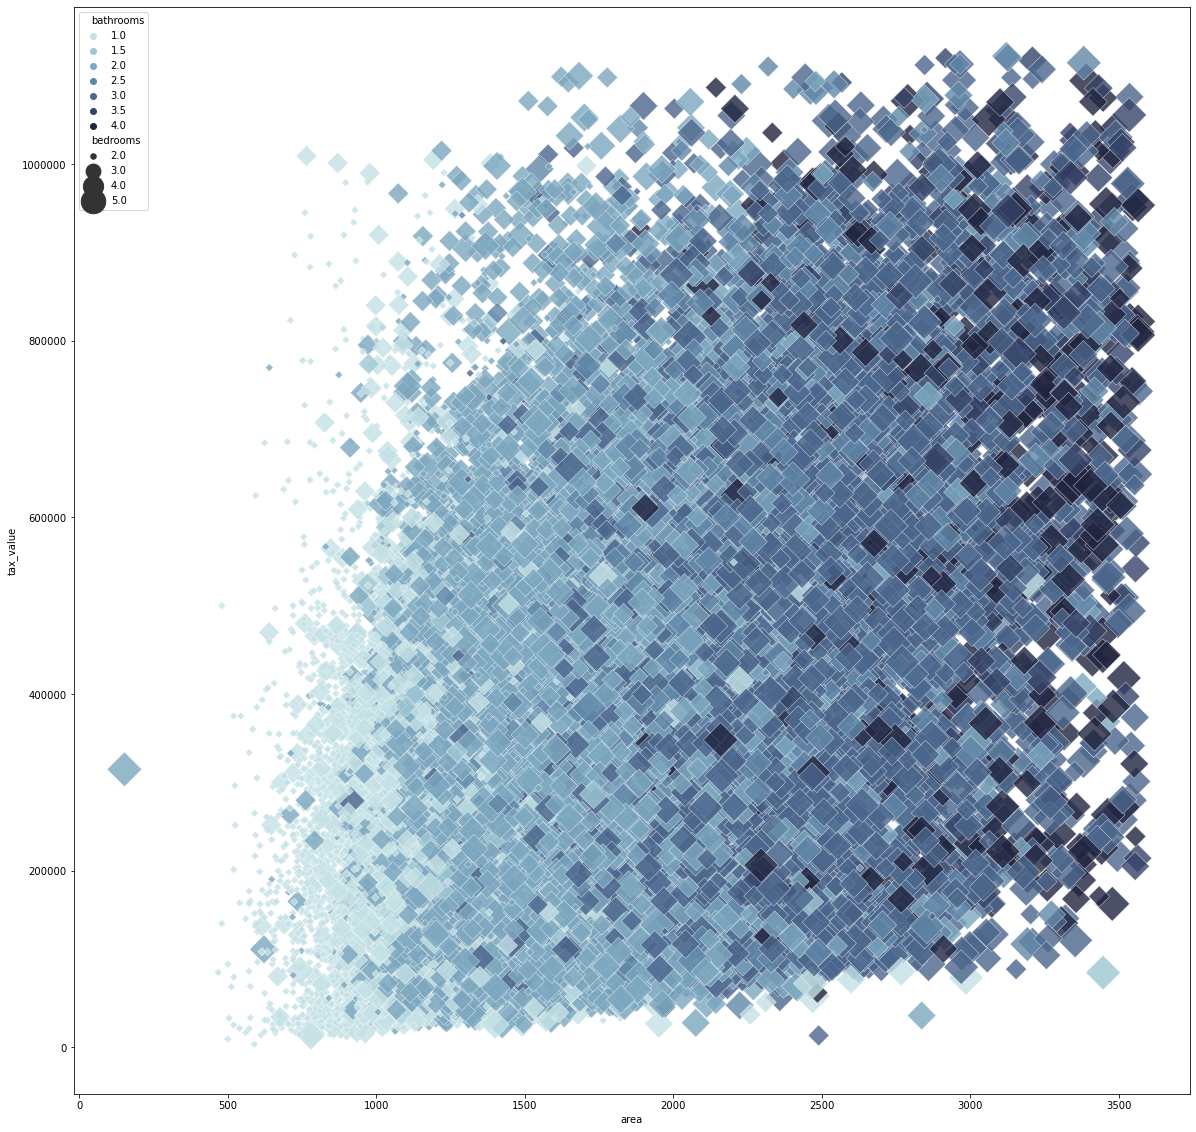

In [309]:
#set figure size
plt.figure(figsize = (20 , 20))

#remove scientific notation
plt.ticklabel_format(useOffset = False, style = 'plain') 

#Set cmap, hue needs to be numerical to use this palette
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)

#create scatterplot
sns.scatterplot(data = train, 
                x = 'area', 
                y = 'tax_value', 
                hue = 'bathrooms',
                size = 'bedrooms',
                sizes = (30,600),
                palette = cmap,
                alpha = 0.8, 
                marker = 'D')

<AxesSubplot:xlabel='lot_size', ylabel='tax_value'>

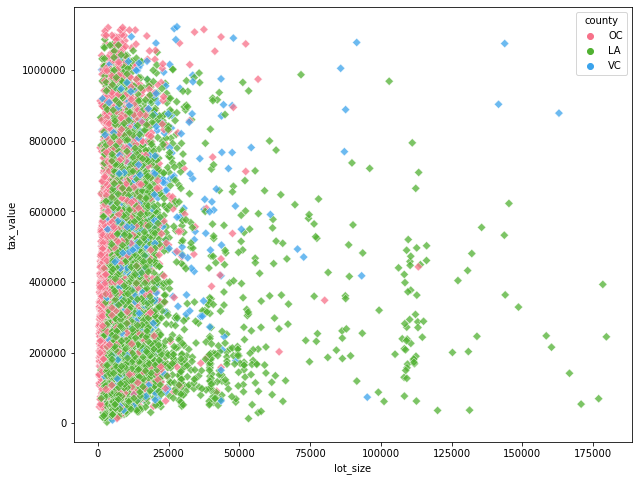

In [256]:
plt.figure(figsize = (10,8))
plt.ticklabel_format(useOffset = False, style = 'plain') 

sns.scatterplot(data = train, 
                x = 'lot_size', 
                y = 'tax_value', 
                hue = 'county',
                palette = 'husl',
                alpha = 0.75, 
                marker = 'D')

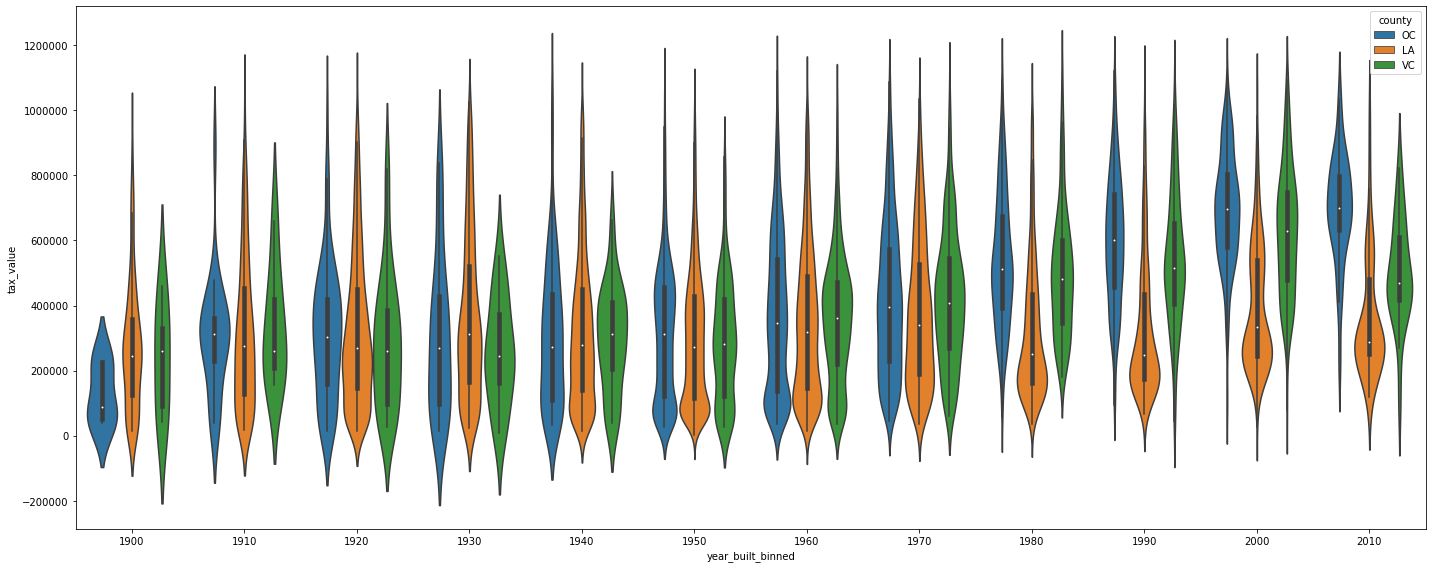

In [257]:
plt.figure(figsize = (20, 8))
plt.ticklabel_format(useOffset = False, style = 'plain') 

sns.violinplot(data = train, 
               x = 'year_built_binned', 
               y = 'tax_value',
               hue = 'county')

plt.tight_layout()

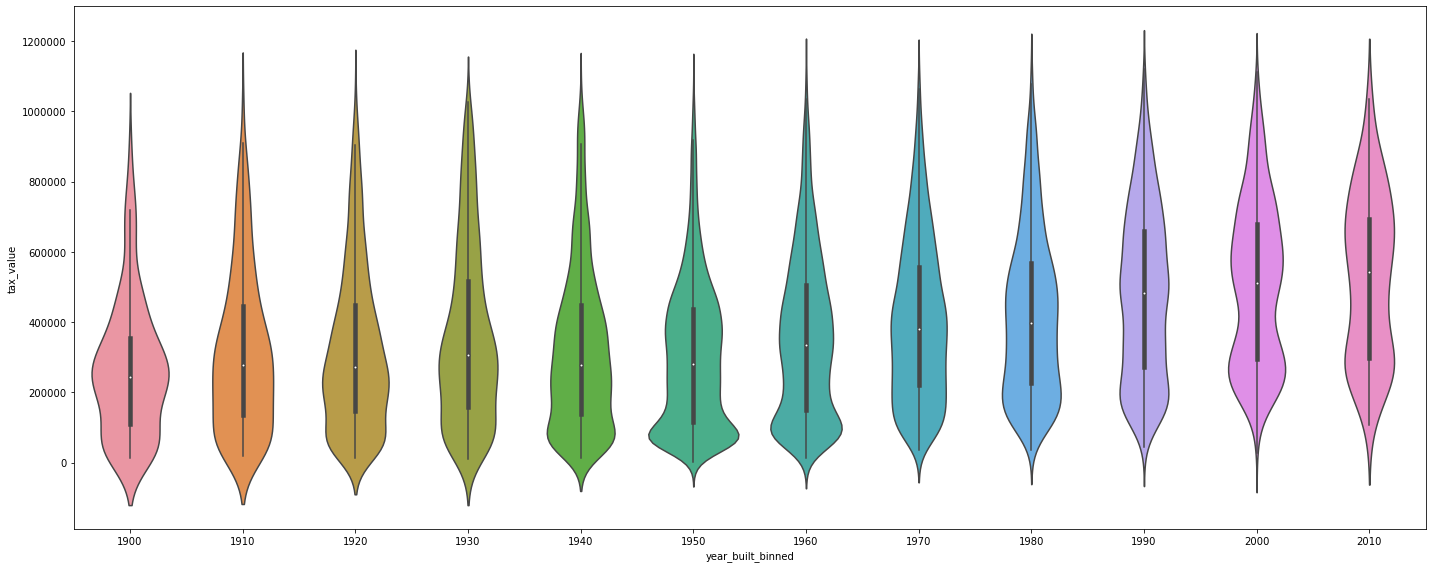

In [226]:
plt.figure(figsize = (20, 8))
plt.ticklabel_format(useOffset = False, style = 'plain') 

sns.violinplot(data = train, 
               x = 'year_built_binned', 
               y = 'tax_value')

plt.tight_layout()

In [260]:
train.tax_value_encoded.value_counts()

0    9466
1    9389
2    6109
Name: tax_value_encoded, dtype: int64

In [262]:
train.tax_value_encoded.dtype

CategoricalDtype(categories=[0, 1, 2], ordered=True)

In [288]:
train.tax_value_encoded.mean()

0.8655263579554558

In [289]:
train.tax_value.mean()

362616.7853308765

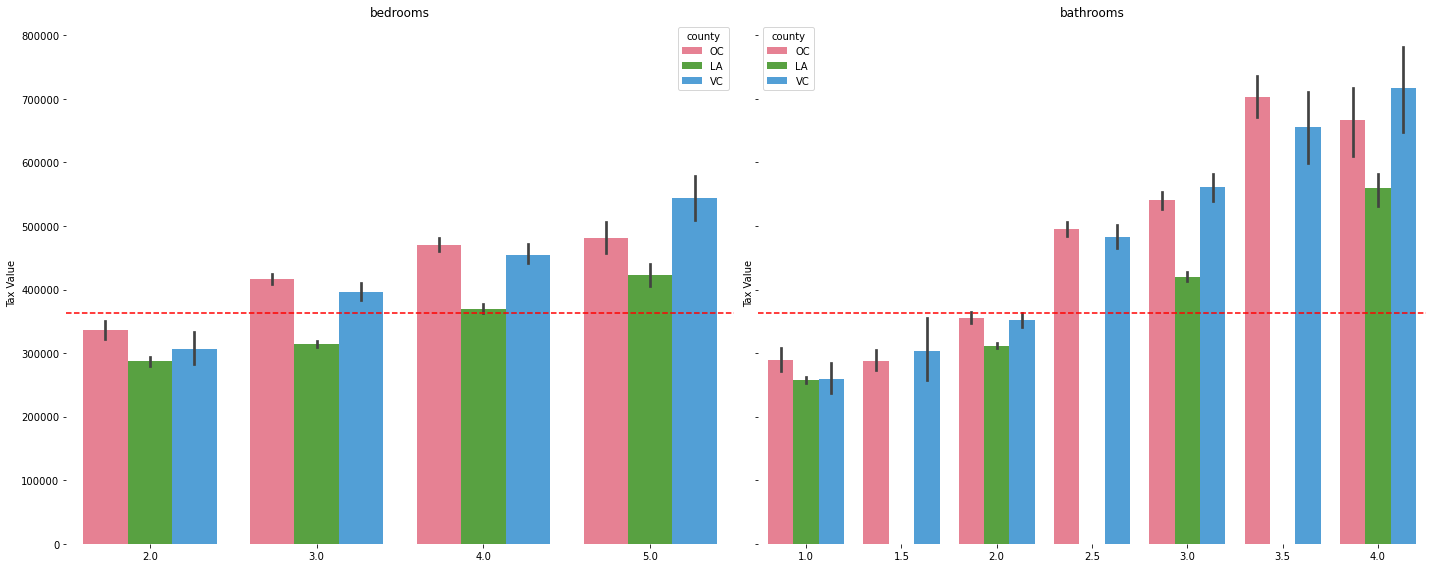

In [294]:
features = ['bedrooms', 'bathrooms']
_, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 8), sharey = True)
for i, feature in enumerate (features):
    sns.barplot(feature, 'tax_value', data = train, ax = ax[i], hue = 'county', palette = 'husl')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Tax Value')
    ax[i].set_title(feature)
    ax[i].axhline(train.tax_value.mean(), ls = '--', color = 'red')

sns.despine(left = True, bottom = True)
plt.tight_layout()    
plt.show()
    

In [ ]:
features = ['area', 'bathrooms']
_, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 8), sharey = True)
for i, feature in enumerate (features):
    sns.barplot(feature, 'tax_value', data = train, ax = ax[i], hue = 'county', palette = 'husl')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Tax Value')
    ax[i].set_title(feature)
    ax[i].axhline(train.tax_value.mean(), ls = '--', color = 'red')

sns.despine(left = True, bottom = True)
plt.tight_layout()    
plt.show()

<AxesSubplot:xlabel='area', ylabel='tax_value'>

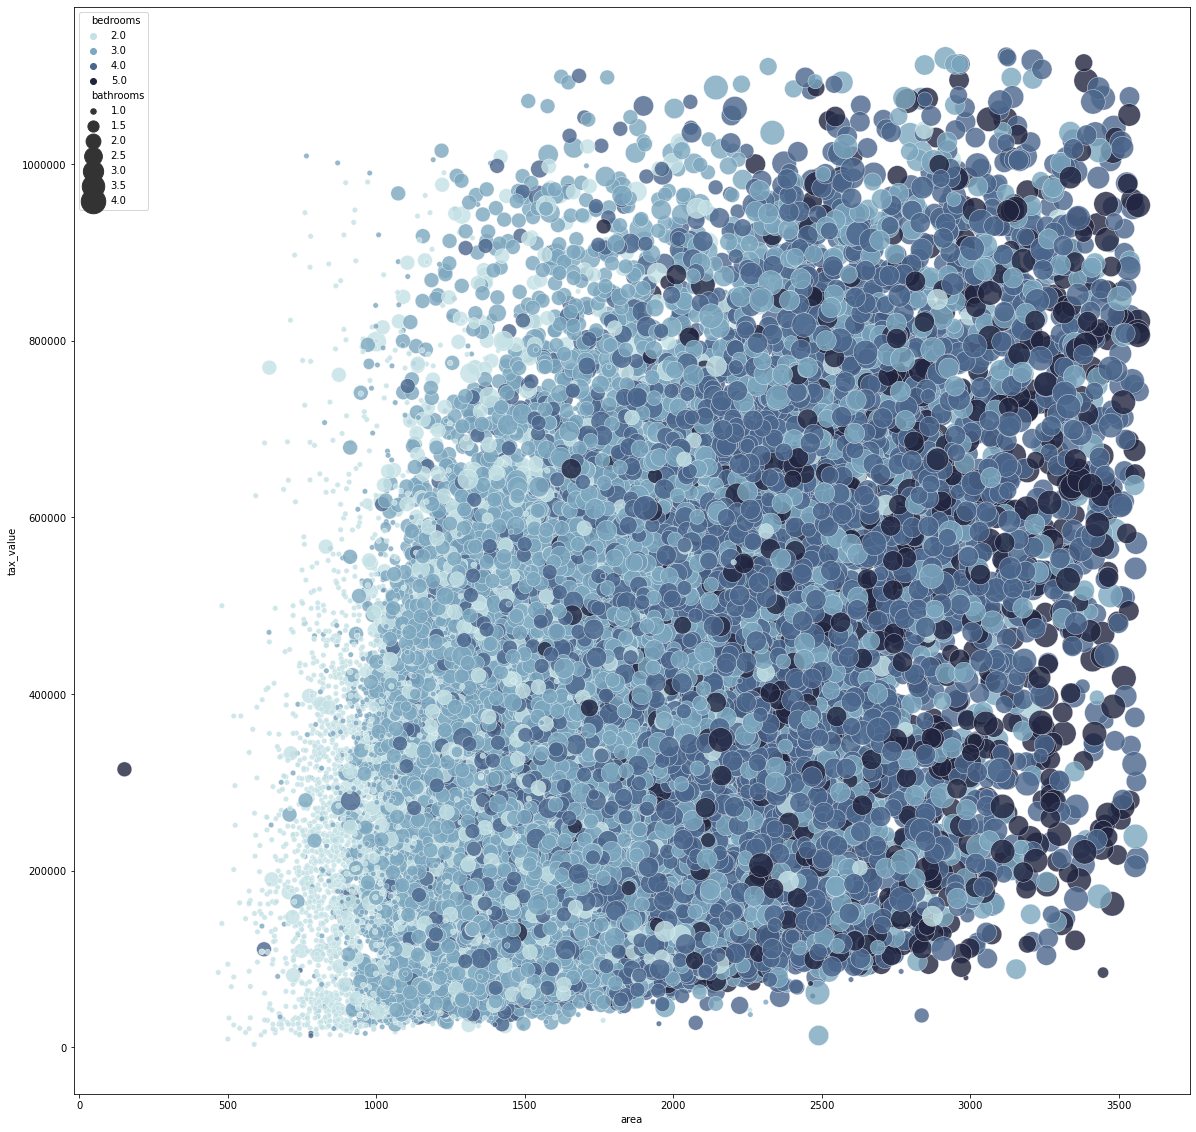

In [300]:
#create figure size
plt.figure(figsize = (20, 20))

#Set cmap
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)

#remove scientific notation on ylabel
plt.ticklabel_format(useOffset = False, style = 'plain') 

#create scatterplot
sns.scatterplot(x = "area", y = "tax_value",
                hue = "bedrooms", size = "bathrooms",
                palette = cmap, sizes = (30, 600),
                data = train,
                alpha = 0.8)

<AxesSubplot:xlabel='area', ylabel='tax_value'>

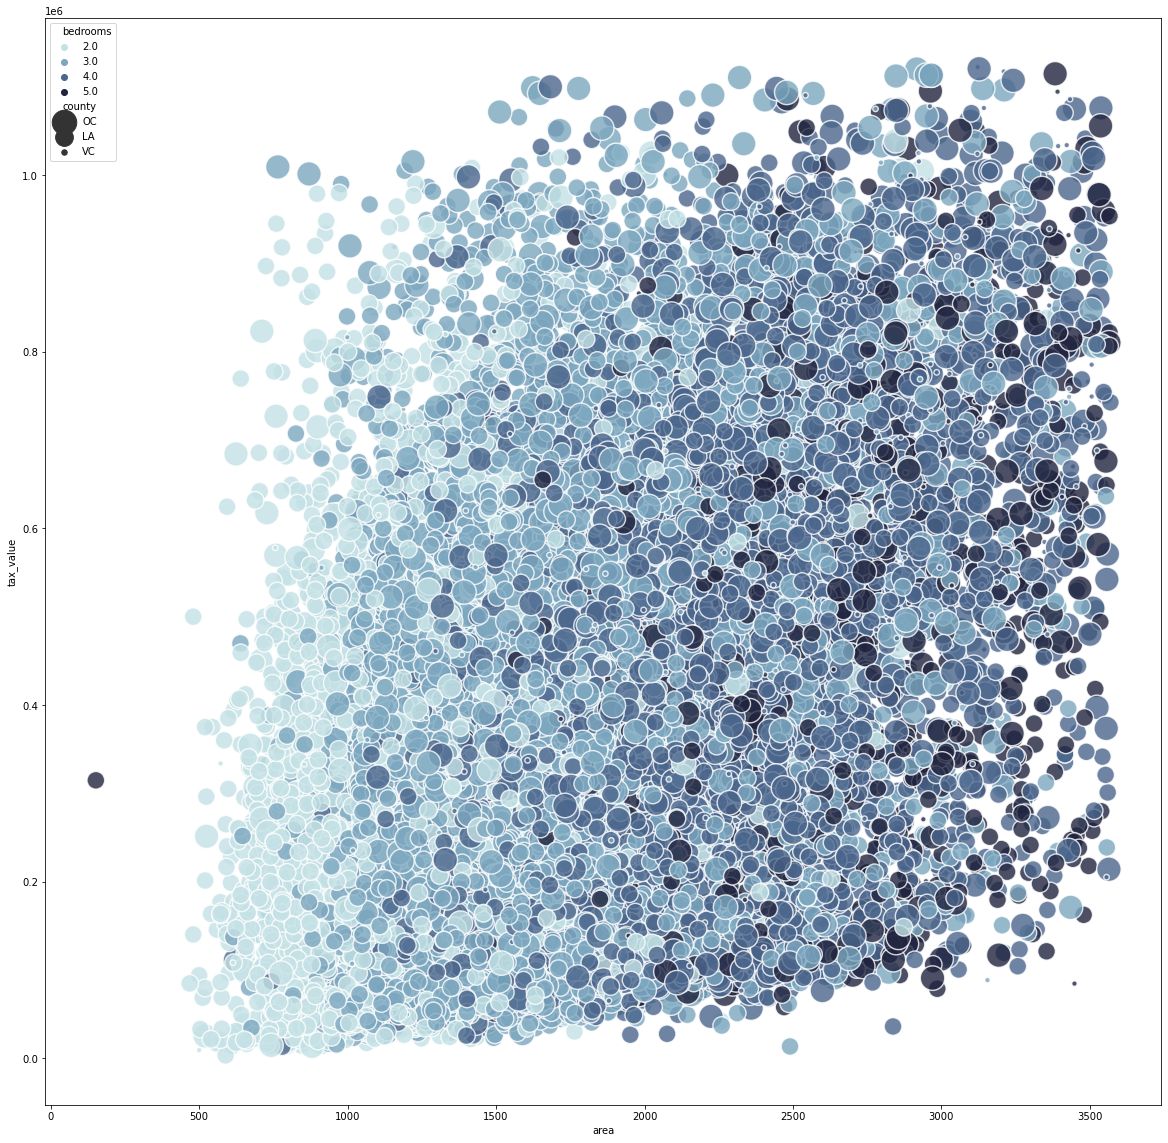

In [298]:
#create figure size
plt.figure(figsize = (20, 20))

#Set cmap
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)


#remove scientific notation on ylabel
plt.ticklabel_format(useOffset = False, style = 'plain') 

#create scatterplot
sns.scatterplot(x = "area", y = "tax_value",
                hue = "bedrooms", size = "county",
                palette = cmap, sizes = (30, 600),
                data = train,
               alpha = 0.8)

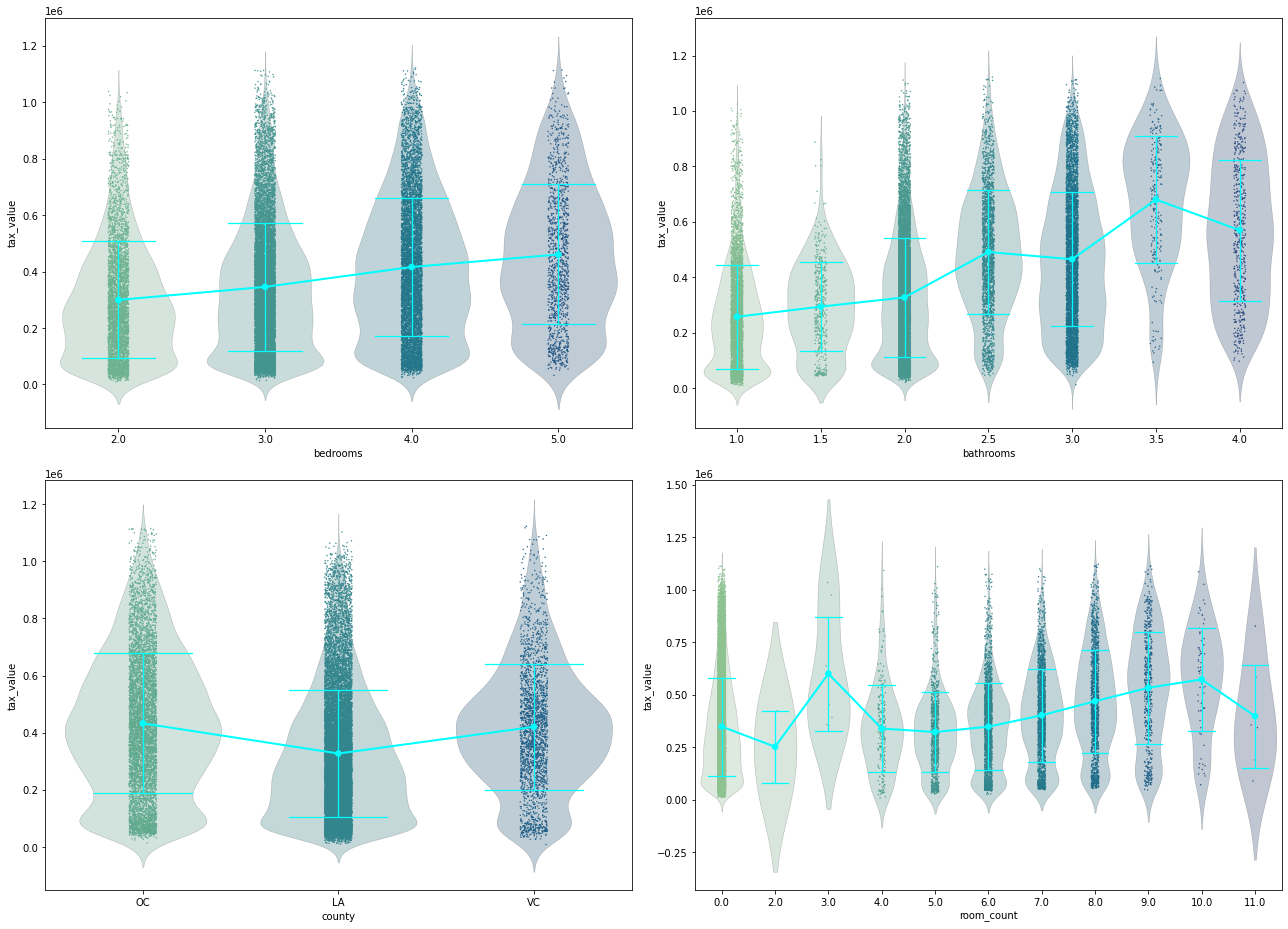

In [14]:
#create categorical columns
cat_cols = ['bedrooms', 'bathrooms', 'county', 'room_count']


#create figure
fig, ax = plt.subplots(3,2, figsize = (18, 19))

#enumerate through cat_cols
for indx, (column, axes) in list(enumerate(list(zip(cat_cols, ax.flatten())))):
    
    #create violin plot
    sns.violinplot(ax = axes, x = train[column],
                  y = train['tax_value'],
                  scale = 'width', 
                   linewidth = 0.5,
                  palette = 'crest', 
                   inner = None)
    
    plt.setp(axes.collections, alpha = 0.3)
    
    #create strip plot to go on top of violin
    sns.stripplot(ax = axes, x = train[column],
                 y = train['tax_value'],
                 palette = 'crest', alpha = 0.9,
                 s = 1.5, jitter = 0.07)
    
    #create pointplot to go on top of strip plot
    sns.pointplot(ax = axes, x = train[column],
                 y = train['tax_value'],
                  #hue = train['county'],
                 color = 'cyan', scale = 0.75,
                 estimator = np.mean, ci = 'sd',
                 errwidth = 1.25, capsize = 0.5, join = True, linewidth = 5.5)
    
    plt.setp(axes.lines, zorder = 100)
    plt.setp(axes.collections, zorder = 100)
    
else:
    [axes.set_visible(False) for axes in ax.flatten()[indx + 1:]]

    
plt.tight_layout()
plt.show()

# MODELING ON SCALED X AND UNSCALED Y

In [316]:
#get baseline, baseline is mean of dependent variable yhat_baseline == baseline

#baseline = round(df.tax_value.mean(),2)
#baseline

363420.69

## Simple Linear Regression (OLS)

In [467]:
#create X's on scaled data

X_train = train_scaled[['bed_and_bath']]
X_validate = validate_scaled[['bed_and_bath']]
X_test = test_scaled[['bed_and_bath']]

# create y's on unscaled data

y_train = train[['tax_value']]
y_validate = validate[['tax_value']]
y_test = test[['tax_value']]

In [468]:
#create model
lr = LinearRegression(normalize = True)

lr.fit(X_train, y_train)

#make predictions on train (yhat)
y_train_pred = np.round(lr.predict(X_train), 2)

#make predictions on validate(yhat)
y_validate_pred = np.round(lr.predict(X_validate), 2)

In [469]:
#add baseline to train df
y_train['baseline'] = round(y_train['tax_value'].mean(), 2)

#add residual baseline to train df
#residual_baseline = baseline - y_train.target
y_train['residual_baseline'] = y_train.baseline - y_train.tax_value

#add predictions to df
y_train['predictions_yhat'] = np.round(y_train_pred, 2)

y_train.head()

tax_value  baseline  residual_baseline  predictions_yhat
1322   295907.00 362616.79           66709.79         346119.02
5951   149000.00 362616.79          213616.79         346119.02
26593  674000.00 362616.79         -311383.21         399623.43
37494  124756.00 362616.79          237860.79         346119.02
46128  212726.00 362616.79          149890.79         346119.02

In [470]:
#add baseline to validate df
y_validate['baseline'] = round(y_validate['tax_value'].mean(), 2)

#add residual baseline to train df
#residual_baseline = baseline - y_train.target
y_validate['residual_baseline'] = y_validate.baseline - y_validate.tax_value

#add predictions to df
y_validate['predictions_yhat'] = np.round(y_validate_pred, 2)

y_validate.head()

tax_value  baseline  residual_baseline  predictions_yhat
11368  535986.00 366934.46         -169051.54         453127.85
19340  358967.00 366934.46            7967.46         399623.43
38145  272141.00 366934.46           94793.46         479880.06
31491  599198.00 366934.46         -232263.54         453127.85
39669  300960.00 366934.46           65974.46         346119.02

In [435]:
#create a dictionary of metric results


metrics = {
           
           'MAE_train': (mean_absolute_error(y_train[['tax_value']], y_train_pred)),
           'MAE_train_baseline': mean_absolute_error(y_train[['tax_value']], y_train.residual_baseline),
           
           'MAE_validate': mean_absolute_error(y_validate[['tax_value']], y_validate_pred),
           'MAE_validate_baseline': mean_absolute_error(y_validate[['tax_value']], y_validate.residual_baseline),
           
           
          'SSE_train': mean_squared_error(y_train[['tax_value']], y_train_pred) * len(y_train),
          'SSE_baseline': mean_squared_error(y_train[['tax_value']], y_train.residual_baseline) * len(y_train),
           
           
          'SSE_validate': mean_squared_error(y_validate[['tax_value']], y_validate_pred) * len(y_validate),
          'SSE_validate_baseline': mean_squared_error(y_validate[['tax_value']], y_validate.residual_baseline) * len(y_validate),
           

          'MSE_train': mean_squared_error(y_train[['tax_value']], y_train_pred),
          'MSE_train_baseline' : mean_squared_error(y_train[['tax_value']], y_train.residual_baseline),
           
          'MSE_validate': mean_squared_error(y_validate[['tax_value']], y_validate_pred),
          'MSE_validate_baseline' : mean_squared_error(y_validate[['tax_value']], y_validate.residual_baseline),
          
          'RMSE_train': np.sqrt(mean_squared_error(y_train[['tax_value']], y_train_pred)),
          'RMSE_train_baseline': np.sqrt(mean_squared_error(y_train[['tax_value']], y_train.residual_baseline)),
        
          'RMSE_validate': np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate_pred)),
          'RMSE_validate_baseline': np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate.residual_baseline))
           
          }



In [456]:
#create metrics df from dictionary
ols_metrics = pd.DataFrame.from_dict(metrics, orient = 'index', columns = ['Results'])

pd.set_option('display.float_format', lambda x: '%.2f'% x)

ols_metrics

Results
MAE_train                        180937.55
MAE_train_baseline               448136.92
MAE_validate                     182896.27
MAE_validate_baseline            454499.89
SSE_train              1225178331286829.00
SSE_baseline           8699547999173413.00
SSE_validate            538818265288610.38
SSE_validate_baseline  3816842980443562.50
MSE_train                   49077805291.09
MSE_train_baseline         348483736547.57
MSE_validate                50361553910.52
MSE_validate_baseline      356747638138.48
RMSE_train                       221535.11
RMSE_train_baseline              590325.11
RMSE_validate                    224413.80
RMSE_validate_baseline           597283.55

In [439]:
#create train residuals array
residual_train = y_train_pred - y_train[['tax_value']]
residual_train_baseline = baseline - y_train[['tax_value']]

#create train residuals df
ols_train_residuals = pd.concat([residual_train, residual_train_baseline], 
                                axis = 1, 
                                keys = ['residual_train', 'residual_train_baseline'])
ols_train_residuals

In [455]:
#create validate residuals array
residual_validate = y_validate_pred - y_validate[['tax_value']]
residual_validate_baseline = baseline - y_validate[['tax_value']]


#create validate residuals df
ols_validate_residuals = pd.concat([residual_validate, residual_validate_baseline], 
                                axis = 1, 
                                keys = ['residual_train', 'residual_train_baseline'])

ols_validate_residuals

residual_train residual_train_baseline
           tax_value               tax_value
1322        50212.02                67513.69
5951       197119.02               214420.69
26593     -274376.57              -310579.31
37494      221363.02               238664.69
46128      133393.02               150694.69
...              ...                     ...
50568      292523.02               309824.69
14339      147023.85                57316.69
25565      174865.43               138662.69
29538     -739868.81              -615558.31
40908      123647.02               140948.69

[24964 rows x 2 columns]

---

In [464]:
#create X's on scaled data

X_train = train_scaled[['area']]
X_validate = validate_scaled[['area']]
X_test = test_scaled[['area']]

# create y's on unscaled data

y_train = train[['tax_value']]
y_validate = validate[['tax_value']]
y_test = test[['tax_value']]

In [465]:
#create model
lr = LinearRegression(normalize = True)

lr.fit(X_train, y_train)

#make predictions on train (yhat)
y_train_pred = np.round(lr.predict(X_train), 2)

#make predictions on validate(yhat)
y_validate_pred = np.round(lr.predict(X_validate), 2)

In [466]:
#add baseline to train df
y_train['baseline'] = round(y_train['tax_value'].mean(), 2)

#add residual baseline to train df
#residual_baseline = baseline - y_train.target
y_train['residual_baseline'] = y_train.baseline - y_train.tax_value

y_train['predictions_yhat'] = np.round(y_train_pred, 2)


y_train.head()

tax_value  baseline  residual_baseline  predictions_yhat
1322   295907.00 362616.79           66709.79         315426.61
5951   149000.00 362616.79          213616.79         379970.54
26593  674000.00 362616.79         -311383.21         372338.10
37494  124756.00 362616.79          237860.79         279089.54
46128  212726.00 362616.79          149890.79         344297.16

In [471]:
#add baseline to validate df
y_validate['baseline'] = round(y_validate['tax_value'].mean(), 2)

#add residual baseline to train df
#residual_baseline = baseline - y_train.target
y_validate['residual_baseline'] = y_validate.baseline - y_validate.tax_value

#add predictions to df
y_validate['predictions_yhat'] = np.round(y_validate_pred, 2)

y_validate.head()

tax_value  baseline  residual_baseline  predictions_yhat
11368  535986.00 366934.46         -169051.54         453127.85
19340  358967.00 366934.46            7967.46         399623.43
38145  272141.00 366934.46           94793.46         479880.06
31491  599198.00 366934.46         -232263.54         453127.85
39669  300960.00 366934.46           65974.46         346119.02

In [472]:
#create a dictionary of metric results


metrics = {
           
           'MAE_train': (mean_absolute_error(y_train[['tax_value']], y_train_pred)),
           'MAE_train_baseline': mean_absolute_error(y_train[['tax_value']], y_train.residual_baseline),
           
           'MAE_validate': mean_absolute_error(y_validate[['tax_value']], y_validate_pred),
           'MAE_validate_baseline': mean_absolute_error(y_validate[['tax_value']], y_validate.residual_baseline),
           
           
          'SSE_train': mean_squared_error(y_train[['tax_value']], y_train_pred) * len(y_train),
          'SSE_baseline': mean_squared_error(y_train[['tax_value']], y_train.residual_baseline) * len(y_train),
           
           
          'SSE_validate': mean_squared_error(y_validate[['tax_value']], y_validate_pred) * len(y_validate),
          'SSE_validate_baseline': mean_squared_error(y_validate[['tax_value']], y_validate.residual_baseline) * len(y_validate),
           

          'MSE_train': mean_squared_error(y_train[['tax_value']], y_train_pred),
          'MSE_train_baseline' : mean_squared_error(y_train[['tax_value']], y_train.residual_baseline),
           
          'MSE_validate': mean_squared_error(y_validate[['tax_value']], y_validate_pred),
          'MSE_validate_baseline' : mean_squared_error(y_validate[['tax_value']], y_validate.residual_baseline),
          
          'RMSE_train': np.sqrt(mean_squared_error(y_train[['tax_value']], y_train_pred)),
          'RMSE_train_baseline': np.sqrt(mean_squared_error(y_train[['tax_value']], y_train.residual_baseline)),
        
          'RMSE_validate': np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate_pred)),
          'RMSE_validate_baseline': np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate.residual_baseline))
           
          }



In [473]:
#create metrics df from dictionary
ols_metrics = pd.DataFrame.from_dict(metrics, orient = 'index', columns = ['Results'])

pd.set_option('display.float_format', lambda x: '%.2f'% x)

ols_metrics

Results
MAE_train                        180937.55
MAE_train_baseline               448136.92
MAE_validate                     182896.27
MAE_validate_baseline            454499.89
SSE_train              1225178331286829.00
SSE_baseline           8699547999173413.00
SSE_validate            538818265288610.38
SSE_validate_baseline  3816842980443562.50
MSE_train                   49077805291.09
MSE_train_baseline         348483736547.57
MSE_validate                50361553910.52
MSE_validate_baseline      356747638138.48
RMSE_train                       221535.11
RMSE_train_baseline              590325.11
RMSE_validate                    224413.80
RMSE_validate_baseline           597283.55

In [474]:
#create train residuals array
residual_train = y_train_pred - y_train[['tax_value']]
residual_train_baseline = baseline - y_train[['tax_value']]

#create train residuals df
ols_train_residuals = pd.concat([residual_train, residual_train_baseline], 
                                axis = 1, 
                                keys = ['residual_train', 'residual_train_baseline'])
ols_train_residuals

residual_train residual_train_baseline
           tax_value               tax_value
1322        50212.02                67513.69
5951       197119.02               214420.69
26593     -274376.57              -310579.31
37494      221363.02               238664.69
46128      133393.02               150694.69
...              ...                     ...
50568      292523.02               309824.69
14339      147023.85                57316.69
25565      174865.43               138662.69
29538     -739868.81              -615558.31
40908      123647.02               140948.69

[24964 rows x 2 columns]

In [475]:
#create validate residuals array
residual_validate = y_validate_pred - y_validate[['tax_value']]
residual_validate_baseline = baseline - y_validate[['tax_value']]


#create validate residuals df
ols_validate_residuals = pd.concat([residual_validate, residual_validate_baseline], 
                                axis = 1, 
                                keys = ['residual_train', 'residual_train_baseline'])

ols_validate_residuals

residual_train residual_train_baseline
           tax_value               tax_value
11368      -82858.15              -172565.31
19340       40656.43                 4453.69
38145      207739.06                91279.69
31491     -146070.15              -235777.31
39669       45159.02                62460.69
...              ...                     ...
29298     -242981.19              -198927.31
33098      155841.43               119638.69
48289      283415.02               300716.69
34891     -453367.57              -489570.31
38398     -120736.98              -103435.31

[10699 rows x 2 columns]

---

In [478]:
#create X's on scaled data

X_train = train_scaled[['bedrooms']]
X_validate = validate_scaled[['bedrooms']]
X_test = test_scaled[['bedrooms']]

# create y's on unscaled data

y_train = train[['tax_value']]
y_validate = validate[['tax_value']]
y_test = test[['tax_value']]

In [479]:
#create model
lr = LinearRegression(normalize = True)

lr.fit(X_train, y_train)

#make predictions on train (yhat)
y_train_pred = np.round(lr.predict(X_train), 2)

#make predictions on validate(yhat)
y_validate_pred = np.round(lr.predict(X_validate), 2)

In [481]:
#add baseline to train df
y_train['baseline'] = round(y_train['tax_value'].mean(), 2)

#add residual baseline to train df
#residual_baseline = baseline - y_train.target
y_train['residual_baseline'] = y_train.baseline - y_train.tax_value

y_train['predictions_yhat'] = np.round(y_train_pred, 2)


y_train.head()

tax_value  baseline  residual_baseline  predictions_yhat
1322   295907.00 362616.79           66709.79         350282.16
5951   149000.00 362616.79          213616.79         350282.16
26593  674000.00 362616.79         -311383.21         350282.16
37494  124756.00 362616.79          237860.79         350282.16
46128  212726.00 362616.79          149890.79         350282.16
...          ...       ...                ...               ...
2335   395000.00 362616.79          -32383.21         292304.10
35790  375000.00 362616.79          -12383.21         350282.16
40534  427488.00 362616.79          -64871.21         350282.16
19060  266235.00 362616.79           96381.79         350282.16
38800  171497.00 362616.79          191119.79         350282.16

[100 rows x 4 columns]

In [482]:
#add baseline to validate df
y_validate['baseline'] = round(y_validate['tax_value'].mean(), 2)

#add residual baseline to train df
#residual_baseline = baseline - y_train.target
y_validate['residual_baseline'] = y_validate.baseline - y_validate.tax_value

#add predictions to df
y_validate['predictions_yhat'] = np.round(y_validate_pred, 2)

y_validate.head()

tax_value  baseline  residual_baseline  predictions_yhat
11368  535986.00 366934.46         -169051.54         408260.23
19340  358967.00 366934.46            7967.46         408260.23
38145  272141.00 366934.46           94793.46         466238.30
31491  599198.00 366934.46         -232263.54         408260.23
39669  300960.00 366934.46           65974.46         350282.16

In [483]:
#create a dictionary of metric results


metrics = {
           
           'MAE_train': (mean_absolute_error(y_train[['tax_value']], y_train_pred)),
           'MAE_train_baseline': mean_absolute_error(y_train[['tax_value']], y_train.residual_baseline),
           
           'MAE_validate': mean_absolute_error(y_validate[['tax_value']], y_validate_pred),
           'MAE_validate_baseline': mean_absolute_error(y_validate[['tax_value']], y_validate.residual_baseline),
           
           
          'SSE_train': mean_squared_error(y_train[['tax_value']], y_train_pred) * len(y_train),
          'SSE_baseline': mean_squared_error(y_train[['tax_value']], y_train.residual_baseline) * len(y_train),
           
           
          'SSE_validate': mean_squared_error(y_validate[['tax_value']], y_validate_pred) * len(y_validate),
          'SSE_validate_baseline': mean_squared_error(y_validate[['tax_value']], y_validate.residual_baseline) * len(y_validate),
           

          'MSE_train': mean_squared_error(y_train[['tax_value']], y_train_pred),
          'MSE_train_baseline' : mean_squared_error(y_train[['tax_value']], y_train.residual_baseline),
           
          'MSE_validate': mean_squared_error(y_validate[['tax_value']], y_validate_pred),
          'MSE_validate_baseline' : mean_squared_error(y_validate[['tax_value']], y_validate.residual_baseline),
          
          'RMSE_train': np.sqrt(mean_squared_error(y_train[['tax_value']], y_train_pred)),
          'RMSE_train_baseline': np.sqrt(mean_squared_error(y_train[['tax_value']], y_train.residual_baseline)),
        
          'RMSE_validate': np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate_pred)),
          'RMSE_validate_baseline': np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate.residual_baseline))
           
          }



In [484]:
#create metrics df from dictionary
ols_metrics = pd.DataFrame.from_dict(metrics, orient = 'index', columns = ['Results'])

pd.set_option('display.float_format', lambda x: '%.2f'% x)

ols_metrics

Results
MAE_train                        186465.02
MAE_train_baseline               448136.92
MAE_validate                     188692.40
MAE_validate_baseline            454499.89
SSE_train              1301890352707220.75
SSE_baseline           8699547999173413.00
SSE_validate            573030221846657.50
SSE_validate_baseline  3816842980443562.50
MSE_train                   52150711132.32
MSE_train_baseline         348483736547.57
MSE_validate                53559231876.50
MSE_validate_baseline      356747638138.48
RMSE_train                       228365.30
RMSE_train_baseline              590325.11
RMSE_validate                    231428.68
RMSE_validate_baseline           597283.55

In [485]:
#create train residuals array
residual_train = y_train_pred - y_train[['tax_value']]
residual_train_baseline = baseline - y_train[['tax_value']]

#create train residuals df
ols_train_residuals = pd.concat([residual_train, residual_train_baseline], 
                                axis = 1, 
                                keys = ['residual_train', 'residual_train_baseline'])
ols_train_residuals

residual_train residual_train_baseline
           tax_value               tax_value
1322        54375.16                67513.69
5951       201282.16               214420.69
26593     -323717.84              -310579.31
37494      225526.16               238664.69
46128      137556.16               150694.69
...              ...                     ...
50568      296686.16               309824.69
14339      102156.23                57316.69
25565      183502.23               138662.69
29538     -686674.90              -615558.31
40908      127810.16               140948.69

[24964 rows x 2 columns]

In [487]:
#create validate residuals array
residual_validate = y_validate_pred - y_validate[['tax_value']]
residual_validate_baseline = baseline - y_validate[['tax_value']]


#create validate residuals df
ols_validate_residuals = pd.concat([residual_validate, residual_validate_baseline], 
                                axis = 1, 
                                keys = ['residual_train', 'residual_train_baseline'])

ols_validate_residuals

residual_train residual_train_baseline
           tax_value               tax_value
11368     -127725.77              -172565.31
19340       49293.23                 4453.69
38145      194097.30                91279.69
31491     -190937.77              -235777.31
39669       49322.16                62460.69
...              ...                     ...
29298     -270043.90              -198927.31
33098      106500.16               119638.69
48289      287578.16               300716.69
34891     -502708.84              -489570.31
38398     -116573.84              -103435.31

[10699 rows x 2 columns]

---

## Multiple Linear Regression

In [499]:
#create X's on scaled data
X_train = train_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code']]
X_validate = validate_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code']]
X_test = test_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code']]

#create y's on unscaled data
y_train = train[['tax_value']]
y_validate = validate[['tax_value']]
y_test = test[['tax_value']]

In [500]:
#create model
lr = LinearRegression(normalize = True)

lr.fit(X_train, y_train)

#make predictions on train (yhat)
y_train_pred = np.round(lr.predict(X_train), 2)

#make predictions on validate(yhat)
y_validate_pred = np.round(lr.predict(X_validate), 2)

In [501]:
#add baseline to train df
y_train['baseline'] = round(y_train['tax_value'].mean(), 2)

#add residual baseline to train df
#residual_baseline = baseline - y_train.target
y_train['residual_baseline'] = y_train.baseline - y_train.tax_value

y_train['predictions_yhat'] = np.round(y_train_pred, 2)


y_train.head()

tax_value  baseline  residual_baseline  predictions_yhat
1322   295907.00 362616.79           66709.79         362831.20
5951   149000.00 362616.79          213616.79         364719.28
26593  674000.00 362616.79         -311383.21         356616.23
37494  124756.00 362616.79          237860.79         254437.20
46128  212726.00 362616.79          149890.79         325871.99

In [502]:
#add baseline to validate df
y_validate['baseline'] = round(y_validate['tax_value'].mean(), 2)

#add residual baseline to train df
#residual_baseline = baseline - y_train.target
y_validate['residual_baseline'] = y_validate.baseline - y_validate.tax_value

#add predictions to df
y_validate['predictions_yhat'] = np.round(y_validate_pred, 2)

y_validate.head()

tax_value  baseline  residual_baseline  predictions_yhat
11368  535986.00 366934.46         -169051.54         474022.46
19340  358967.00 366934.46            7967.46         354068.65
38145  272141.00 366934.46           94793.46         513407.47
31491  599198.00 366934.46         -232263.54         496866.43
39669  300960.00 366934.46           65974.46         272979.76

In [503]:
#create a dictionary of metric results


metrics = {
           
           'MAE_train': (mean_absolute_error(y_train[['tax_value']], y_train_pred)),
           'MAE_train_baseline': mean_absolute_error(y_train[['tax_value']], y_train.residual_baseline),
           
           'MAE_validate': mean_absolute_error(y_validate[['tax_value']], y_validate_pred),
           'MAE_validate_baseline': mean_absolute_error(y_validate[['tax_value']], y_validate.residual_baseline),
           
           
          'SSE_train': mean_squared_error(y_train[['tax_value']], y_train_pred) * len(y_train),
          'SSE_baseline': mean_squared_error(y_train[['tax_value']], y_train.residual_baseline) * len(y_train),
           
           
          'SSE_validate': mean_squared_error(y_validate[['tax_value']], y_validate_pred) * len(y_validate),
          'SSE_validate_baseline': mean_squared_error(y_validate[['tax_value']], y_validate.residual_baseline) * len(y_validate),
           

          'MSE_train': mean_squared_error(y_train[['tax_value']], y_train_pred),
          'MSE_train_baseline' : mean_squared_error(y_train[['tax_value']], y_train.residual_baseline),
           
          'MSE_validate': mean_squared_error(y_validate[['tax_value']], y_validate_pred),
          'MSE_validate_baseline' : mean_squared_error(y_validate[['tax_value']], y_validate.residual_baseline),
          
          'RMSE_train': np.sqrt(mean_squared_error(y_train[['tax_value']], y_train_pred)),
          'RMSE_train_baseline': np.sqrt(mean_squared_error(y_train[['tax_value']], y_train.residual_baseline)),
        
          'RMSE_validate': np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate_pred)),
          'RMSE_validate_baseline': np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate.residual_baseline))
           
          }



In [504]:
#create metrics df from dictionary
ols_metrics = pd.DataFrame.from_dict(metrics, orient = 'index', columns = ['Results'])

pd.set_option('display.float_format', lambda x: '%.2f'% x)

ols_metrics

Results
MAE_train                        168982.68
MAE_train_baseline               448136.92
MAE_validate                     170632.22
MAE_validate_baseline            454499.89
SSE_train              1069274510191011.50
SSE_baseline           8699547999173413.00
SSE_validate            468695768307253.25
SSE_validate_baseline  3816842980443562.50
MSE_train                   42832659437.23
MSE_train_baseline         348483736547.57
MSE_validate                43807436985.44
MSE_validate_baseline      356747638138.48
RMSE_train                       206960.53
RMSE_train_baseline              590325.11
RMSE_validate                    209302.26
RMSE_validate_baseline           597283.55

In [497]:
#create train residuals array
residual_train = y_train_pred - y_train[['tax_value']]
residual_train_baseline = baseline - y_train[['tax_value']]

#create train residuals df
ols_train_residuals = pd.concat([residual_train, residual_train_baseline], 
                                axis = 1, 
                                keys = ['residual_train', 'residual_train_baseline'])
ols_train_residuals

residual_train residual_train_baseline
           tax_value               tax_value
1322        66736.59                67513.69
5951       215941.10               214420.69
26593     -317417.80              -310579.31
37494      129702.34               238664.69
46128      113146.36               150694.69
...              ...                     ...
50568      218852.13               309824.69
14339      215889.73                57316.69
25565       90262.28               138662.69
29538     -744677.06              -615558.31
40908      153800.22               140948.69

[24964 rows x 2 columns]

In [498]:
#create validate residuals array
residual_validate = y_validate_pred - y_validate[['tax_value']]
residual_validate_baseline = baseline - y_validate[['tax_value']]


#create validate residuals df
ols_validate_residuals = pd.concat([residual_validate, residual_validate_baseline], 
                                axis = 1, 
                                keys = ['residual_train', 'residual_train_baseline'])

ols_validate_residuals

residual_train residual_train_baseline
           tax_value               tax_value
11368      -62029.84              -172565.31
19340       -4942.78                 4453.69
38145      241276.53                91279.69
31491     -102527.45              -235777.31
39669      -27966.72                62460.69
...              ...                     ...
29298       -5276.95              -198927.31
33098      275318.26               119638.69
48289      218103.02               300716.69
34891     -171074.05              -489570.31
38398      -58965.36              -103435.31

[10699 rows x 2 columns]

---

In [507]:
#create X's on scaled data

X_train = train_scaled[['bedrooms','area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms']]
X_validate = validate_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms']]
X_test = test_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms']]

# create y's on unscaled data

y_train = train[['tax_value']]
y_validate = validate[['tax_value']]
y_test = test[['tax_value']]

In [508]:
#create model
lr = LinearRegression(normalize = True)

lr.fit(X_train, y_train)

#make predictions on train (yhat)
y_train_pred = np.round(lr.predict(X_train), 2)

#make predictions on validate(yhat)
y_validate_pred = np.round(lr.predict(X_validate), 2)

In [509]:
#add baseline to train df
y_train['baseline'] = round(y_train['tax_value'].mean(), 2)

#add residual baseline to train df
#residual_baseline = baseline - y_train.target
y_train['residual_baseline'] = y_train.baseline - y_train.tax_value

y_train['predictions_yhat'] = np.round(y_train_pred, 2)


y_train.head()

tax_value  baseline  residual_baseline  predictions_yhat
1322   295907.00 362616.79           66709.79         366284.53
5951   149000.00 362616.79          213616.79         361066.38
26593  674000.00 362616.79         -311383.21         382743.28
37494  124756.00 362616.79          237860.79         264528.31
46128  212726.00 362616.79          149890.79         327107.32

In [510]:
#add baseline to validate df
y_validate['baseline'] = round(y_validate['tax_value'].mean(), 2)

#add residual baseline to train df
#residual_baseline = baseline - y_train.target
y_validate['residual_baseline'] = y_validate.baseline - y_validate.tax_value

#add predictions to df
y_validate['predictions_yhat'] = np.round(y_validate_pred, 2)

y_validate.head()

tax_value  baseline  residual_baseline  predictions_yhat
11368  535986.00 366934.46         -169051.54         476889.97
19340  358967.00 366934.46            7967.46         343115.70
38145  272141.00 366934.46           94793.46         495661.40
31491  599198.00 366934.46         -232263.54         496940.18
39669  300960.00 366934.46           65974.46         280772.84

In [511]:
#create a dictionary of metric results


metrics = {
           
           'MAE_train': (mean_absolute_error(y_train[['tax_value']], y_train_pred)),
           'MAE_train_baseline': mean_absolute_error(y_train[['tax_value']], y_train.residual_baseline),
           
           'MAE_validate': mean_absolute_error(y_validate[['tax_value']], y_validate_pred),
           'MAE_validate_baseline': mean_absolute_error(y_validate[['tax_value']], y_validate.residual_baseline),
           
           
          'SSE_train': mean_squared_error(y_train[['tax_value']], y_train_pred) * len(y_train),
          'SSE_baseline': mean_squared_error(y_train[['tax_value']], y_train.residual_baseline) * len(y_train),
           
           
          'SSE_validate': mean_squared_error(y_validate[['tax_value']], y_validate_pred) * len(y_validate),
          'SSE_validate_baseline': mean_squared_error(y_validate[['tax_value']], y_validate.residual_baseline) * len(y_validate),
           

          'MSE_train': mean_squared_error(y_train[['tax_value']], y_train_pred),
          'MSE_train_baseline' : mean_squared_error(y_train[['tax_value']], y_train.residual_baseline),
           
          'MSE_validate': mean_squared_error(y_validate[['tax_value']], y_validate_pred),
          'MSE_validate_baseline' : mean_squared_error(y_validate[['tax_value']], y_validate.residual_baseline),
          
          'RMSE_train': np.sqrt(mean_squared_error(y_train[['tax_value']], y_train_pred)),
          'RMSE_train_baseline': np.sqrt(mean_squared_error(y_train[['tax_value']], y_train.residual_baseline)),
        
          'RMSE_validate': np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate_pred)),
          'RMSE_validate_baseline': np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate.residual_baseline))
           
          }



In [512]:
#create metrics df from dictionary
ols_metrics = pd.DataFrame.from_dict(metrics, orient = 'index', columns = ['Results'])

pd.set_option('display.float_format', lambda x: '%.2f'% x)

ols_metrics

Results
MAE_train                        168648.24
MAE_train_baseline               448136.92
MAE_validate                     170275.78
MAE_validate_baseline            454499.89
SSE_train              1065136468823815.75
SSE_baseline           8699547999173413.00
SSE_validate            467052629972520.75
SSE_validate_baseline  3816842980443562.50
MSE_train                   42666899087.64
MSE_train_baseline         348483736547.57
MSE_validate                43653858301.95
MSE_validate_baseline      356747638138.48
RMSE_train                       206559.67
RMSE_train_baseline              590325.11
RMSE_validate                    208935.06
RMSE_validate_baseline           597283.55

In [513]:
#create train residuals array
residual_train = y_train_pred - y_train[['tax_value']]
residual_train_baseline = baseline - y_train[['tax_value']]

#create train residuals df
ols_train_residuals = pd.concat([residual_train, residual_train_baseline], 
                                axis = 1, 
                                keys = ['residual_train', 'residual_train_baseline'])
ols_train_residuals

residual_train residual_train_baseline
           tax_value               tax_value
1322        70377.53                67513.69
5951       212066.38               214420.69
26593     -291256.72              -310579.31
37494      139772.31               238664.69
46128      114381.32               150694.69
...              ...                     ...
50568      226798.28               309824.69
14339      219555.97                57316.69
25565       90812.55               138662.69
29538     -751955.74              -615558.31
40908      155453.18               140948.69

[24964 rows x 2 columns]

In [514]:
#create validate residuals array
residual_validate = y_validate_pred - y_validate[['tax_value']]
residual_validate_baseline = baseline - y_validate[['tax_value']]


#create validate residuals df
ols_validate_residuals = pd.concat([residual_validate, residual_validate_baseline], 
                                axis = 1, 
                                keys = ['residual_train', 'residual_train_baseline'])

ols_validate_residuals

residual_train residual_train_baseline
           tax_value               tax_value
11368      -59096.03              -172565.31
19340      -15851.30                 4453.69
38145      223520.40                91279.69
31491     -102257.82              -235777.31
39669      -20187.16                62460.69
...              ...                     ...
29298       -2321.39              -198927.31
33098      288007.73               119638.69
48289      224922.09               300716.69
34891     -178486.15              -489570.31
38398      -61220.65              -103435.31

[10699 rows x 2 columns]

---

In [515]:
#create X's on scaled data

X_train = train_scaled[['bedrooms','area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms', 'lot_size']]
X_validate = validate_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms', 'lot_size']]
X_test = test_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms', 'lot_size']]

# create y's on unscaled data

y_train = train[['tax_value']]
y_validate = validate[['tax_value']]
y_test = test[['tax_value']]

In [516]:
#create model
lr = LinearRegression(normalize = True)

lr.fit(X_train, y_train)

#make predictions on train (yhat)
y_train_pred = np.round(lr.predict(X_train), 2)

#make predictions on validate(yhat)
y_validate_pred = np.round(lr.predict(X_validate), 2)

In [517]:
#add baseline to train df
y_train['baseline'] = round(y_train['tax_value'].mean(), 2)

#add residual baseline to train df
#residual_baseline = baseline - y_train.target
y_train['residual_baseline'] = y_train.baseline - y_train.tax_value

y_train['predictions_yhat'] = np.round(y_train_pred, 2)


y_train.head()

tax_value  baseline  residual_baseline  predictions_yhat
1322   295907.00 362616.79           66709.79         365510.21
5951   149000.00 362616.79          213616.79         332132.89
26593  674000.00 362616.79         -311383.21         383453.95
37494  124756.00 362616.79          237860.79         264482.33
46128  212726.00 362616.79          149890.79         326083.41

In [518]:
#add baseline to validate df
y_validate['baseline'] = round(y_validate['tax_value'].mean(), 2)

#add residual baseline to train df
#residual_baseline = baseline - y_train.target
y_validate['residual_baseline'] = y_validate.baseline - y_validate.tax_value

#add predictions to df
y_validate['predictions_yhat'] = np.round(y_validate_pred, 2)

y_validate.head()

tax_value  baseline  residual_baseline  predictions_yhat
11368  535986.00 366934.46         -169051.54         482834.78
19340  358967.00 366934.46            7967.46         334756.42
38145  272141.00 366934.46           94793.46         499341.20
31491  599198.00 366934.46         -232263.54         502154.36
39669  300960.00 366934.46           65974.46         281590.09

In [519]:
#create a dictionary of metric results


metrics = {
           
           'MAE_train': (mean_absolute_error(y_train[['tax_value']], y_train_pred)),
           'MAE_train_baseline': mean_absolute_error(y_train[['tax_value']], y_train.residual_baseline),
           
           'MAE_validate': mean_absolute_error(y_validate[['tax_value']], y_validate_pred),
           'MAE_validate_baseline': mean_absolute_error(y_validate[['tax_value']], y_validate.residual_baseline),
           
           
          'SSE_train': mean_squared_error(y_train[['tax_value']], y_train_pred) * len(y_train),
          'SSE_baseline': mean_squared_error(y_train[['tax_value']], y_train.residual_baseline) * len(y_train),
           
           
          'SSE_validate': mean_squared_error(y_validate[['tax_value']], y_validate_pred) * len(y_validate),
          'SSE_validate_baseline': mean_squared_error(y_validate[['tax_value']], y_validate.residual_baseline) * len(y_validate),
           

          'MSE_train': mean_squared_error(y_train[['tax_value']], y_train_pred),
          'MSE_train_baseline' : mean_squared_error(y_train[['tax_value']], y_train.residual_baseline),
           
          'MSE_validate': mean_squared_error(y_validate[['tax_value']], y_validate_pred),
          'MSE_validate_baseline' : mean_squared_error(y_validate[['tax_value']], y_validate.residual_baseline),
          
          'RMSE_train': np.sqrt(mean_squared_error(y_train[['tax_value']], y_train_pred)),
          'RMSE_train_baseline': np.sqrt(mean_squared_error(y_train[['tax_value']], y_train.residual_baseline)),
        
          'RMSE_validate': np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate_pred)),
          'RMSE_validate_baseline': np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate.residual_baseline))
           
          }



In [520]:
#create metrics df from dictionary
ols_metrics = pd.DataFrame.from_dict(metrics, orient = 'index', columns = ['Results'])

pd.set_option('display.float_format', lambda x: '%.2f'% x)

ols_metrics

Results
MAE_train                        168414.15
MAE_train_baseline               448136.92
MAE_validate                     170148.92
MAE_validate_baseline            454499.89
SSE_train              1063759183754254.50
SSE_baseline           8699547999173413.00
SSE_validate            466699287275886.81
SSE_validate_baseline  3816842980443562.50
MSE_train                   42611728238.83
MSE_train_baseline         348483736547.57
MSE_validate                43620832533.50
MSE_validate_baseline      356747638138.48
RMSE_train                       206426.08
RMSE_train_baseline              590325.11
RMSE_validate                    208856.01
RMSE_validate_baseline           597283.55

In [521]:
#create train residuals array
residual_train = y_train_pred - y_train[['tax_value']]
residual_train_baseline = baseline - y_train[['tax_value']]

#create train residuals df
ols_train_residuals = pd.concat([residual_train, residual_train_baseline], 
                                axis = 1, 
                                keys = ['residual_train', 'residual_train_baseline'])
ols_train_residuals

residual_train residual_train_baseline
           tax_value               tax_value
1322        69603.21                67513.69
5951       183132.89               214420.69
26593     -290546.05              -310579.31
37494      139726.33               238664.69
46128      113357.41               150694.69
...              ...                     ...
50568      228014.82               309824.69
14339      222663.24                57316.69
25565       84195.54               138662.69
29538     -751801.88              -615558.31
40908      156567.72               140948.69

[24964 rows x 2 columns]

In [522]:
#create validate residuals array
residual_validate = y_validate_pred - y_validate[['tax_value']]
residual_validate_baseline = baseline - y_validate[['tax_value']]


#create validate residuals df
ols_validate_residuals = pd.concat([residual_validate, residual_validate_baseline], 
                                axis = 1, 
                                keys = ['residual_train', 'residual_train_baseline'])

ols_validate_residuals

residual_train residual_train_baseline
           tax_value               tax_value
11368      -53151.22              -172565.31
19340      -24210.58                 4453.69
38145      227200.20                91279.69
31491      -97043.64              -235777.31
39669      -19369.91                62460.69
...              ...                     ...
29298        -611.85              -198927.31
33098      288920.80               119638.69
48289      221062.34               300716.69
34891     -174050.42              -489570.31
38398      -61972.23              -103435.31

[10699 rows x 2 columns]

---

In [523]:
#create X's on scaled data

X_train = train_scaled[['bedrooms','area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms', 'lot_size', 'year_built']]
X_validate = validate_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms', 'lot_size', 'year_built']]
X_test = test_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms', 'lot_size', 'year_built']]

# create y's on unscaled data

y_train = train[['tax_value']]
y_validate = validate[['tax_value']]
y_test = test[['tax_value']]

In [524]:
#create model
lr = LinearRegression(normalize = True)

lr.fit(X_train, y_train)

#make predictions on train (yhat)
y_train_pred = np.round(lr.predict(X_train), 2)

#make predictions on validate(yhat)
y_validate_pred = np.round(lr.predict(X_validate), 2)

In [525]:
#add baseline to train df
y_train['baseline'] = round(y_train['tax_value'].mean(), 2)

#add residual baseline to train df
#residual_baseline = baseline - y_train.target
y_train['residual_baseline'] = y_train.baseline - y_train.tax_value

y_train['predictions_yhat'] = np.round(y_train_pred, 2)


y_train.head()

tax_value  baseline  residual_baseline  predictions_yhat
1322   295907.00 362616.79           66709.79         366580.92
5951   149000.00 362616.79          213616.79         324760.83
26593  674000.00 362616.79         -311383.21         388486.87
37494  124756.00 362616.79          237860.79         264266.44
46128  212726.00 362616.79          149890.79         320809.60

In [526]:
#add baseline to validate df
y_validate['baseline'] = round(y_validate['tax_value'].mean(), 2)

#add residual baseline to train df
#residual_baseline = baseline - y_train.target
y_validate['residual_baseline'] = y_validate.baseline - y_validate.tax_value

#add predictions to df
y_validate['predictions_yhat'] = np.round(y_validate_pred, 2)

y_validate.head()

tax_value  baseline  residual_baseline  predictions_yhat
11368  535986.00 366934.46         -169051.54         475596.05
19340  358967.00 366934.46            7967.46         334584.64
38145  272141.00 366934.46           94793.46         502201.16
31491  599198.00 366934.46         -232263.54         507206.00
39669  300960.00 366934.46           65974.46         281925.93

In [527]:
#create a dictionary of metric results


metrics = {
           
           'MAE_train': (mean_absolute_error(y_train[['tax_value']], y_train_pred)),
           'MAE_train_baseline': mean_absolute_error(y_train[['tax_value']], y_train.residual_baseline),
           
           'MAE_validate': mean_absolute_error(y_validate[['tax_value']], y_validate_pred),
           'MAE_validate_baseline': mean_absolute_error(y_validate[['tax_value']], y_validate.residual_baseline),
           
           
          'SSE_train': mean_squared_error(y_train[['tax_value']], y_train_pred) * len(y_train),
          'SSE_baseline': mean_squared_error(y_train[['tax_value']], y_train.residual_baseline) * len(y_train),
           
           
          'SSE_validate': mean_squared_error(y_validate[['tax_value']], y_validate_pred) * len(y_validate),
          'SSE_validate_baseline': mean_squared_error(y_validate[['tax_value']], y_validate.residual_baseline) * len(y_validate),
           

          'MSE_train': mean_squared_error(y_train[['tax_value']], y_train_pred),
          'MSE_train_baseline' : mean_squared_error(y_train[['tax_value']], y_train.residual_baseline),
           
          'MSE_validate': mean_squared_error(y_validate[['tax_value']], y_validate_pred),
          'MSE_validate_baseline' : mean_squared_error(y_validate[['tax_value']], y_validate.residual_baseline),
          
          'RMSE_train': np.sqrt(mean_squared_error(y_train[['tax_value']], y_train_pred)),
          'RMSE_train_baseline': np.sqrt(mean_squared_error(y_train[['tax_value']], y_train.residual_baseline)),
        
          'RMSE_validate': np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate_pred)),
          'RMSE_validate_baseline': np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate.residual_baseline))
           
          }



In [528]:
#create metrics df from dictionary
ols_metrics = pd.DataFrame.from_dict(metrics, orient = 'index', columns = ['Results'])

pd.set_option('display.float_format', lambda x: '%.2f'% x)

ols_metrics

Results
MAE_train                        168291.98
MAE_train_baseline               448136.92
MAE_validate                     170001.14
MAE_validate_baseline            454499.89
SSE_train              1063331219825759.88
SSE_baseline           8699547999173413.00
SSE_validate            466305461023144.06
SSE_validate_baseline  3816842980443562.50
MSE_train                   42594584995.42
MSE_train_baseline         348483736547.57
MSE_validate                43584022901.50
MSE_validate_baseline      356747638138.48
RMSE_train                       206384.56
RMSE_train_baseline              590325.11
RMSE_validate                    208767.87
RMSE_validate_baseline           597283.55

In [529]:
#create train residuals array
residual_train = y_train_pred - y_train[['tax_value']]
residual_train_baseline = baseline - y_train[['tax_value']]

#create train residuals df
ols_train_residuals = pd.concat([residual_train, residual_train_baseline], 
                                axis = 1, 
                                keys = ['residual_train', 'residual_train_baseline'])
ols_train_residuals

residual_train residual_train_baseline
           tax_value               tax_value
1322        70673.92                67513.69
5951       175760.83               214420.69
26593     -285513.13              -310579.31
37494      139510.44               238664.69
46128      108083.60               150694.69
...              ...                     ...
50568      229554.81               309824.69
14339      225540.55                57316.69
25565       79812.85               138662.69
29538     -755496.45              -615558.31
40908      154519.14               140948.69

[24964 rows x 2 columns]

In [530]:
#create validate residuals array
residual_validate = y_validate_pred - y_validate[['tax_value']]
residual_validate_baseline = baseline - y_validate[['tax_value']]


#create validate residuals df
ols_validate_residuals = pd.concat([residual_validate, residual_validate_baseline], 
                                axis = 1, 
                                keys = ['residual_train', 'residual_train_baseline'])

ols_validate_residuals

residual_train residual_train_baseline
           tax_value               tax_value
11368      -60389.95              -172565.31
19340      -24382.36                 4453.69
38145      230060.16                91279.69
31491      -91992.00              -235777.31
39669      -19034.07                62460.69
...              ...                     ...
29298        2687.50              -198927.31
33098      293280.07               119638.69
48289      220033.80               300716.69
34891     -175171.78              -489570.31
38398      -62156.03              -103435.31

[10699 rows x 2 columns]

---

In [531]:
#create X's on scaled data

X_train = train_scaled[['bedrooms','area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms','lot_size', 'year_built', 'census_tract']]
X_validate = validate_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms', 'lot_size', 'year_built', 'census_tract']]
X_test = test_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms', 'lot_size', 'year_built', 'census_tract']]

# create y's on unscaled data

y_train = train[['tax_value']]
y_validate = validate[['tax_value']]
y_test = test[['tax_value']]


#create model
lr = LinearRegression(normalize = True)

lr.fit(X_train, y_train)

#make predictions on train (yhat)
y_train_pred = np.round(lr.predict(X_train), 2)

#make predictions on validate(yhat)
y_validate_pred = np.round(lr.predict(X_validate), 2)

In [532]:
#add baseline to train df
y_train['baseline'] = round(y_train['tax_value'].mean(), 2)

#add residual baseline to train df
#residual_baseline = baseline - y_train.target
y_train['residual_baseline'] = y_train.baseline - y_train.tax_value

y_train['predictions_yhat'] = np.round(y_train_pred, 2)


y_train.head()

tax_value  baseline  residual_baseline  predictions_yhat
1322   295907.00 362616.79           66709.79         353463.87
5951   149000.00 362616.79          213616.79         289411.57
26593  674000.00 362616.79         -311383.21         429733.49
37494  124756.00 362616.79          237860.79         274890.64
46128  212726.00 362616.79          149890.79         347444.36

In [533]:
#add baseline to validate df
y_validate['baseline'] = round(y_validate['tax_value'].mean(), 2)

#add residual baseline to train df
#residual_baseline = baseline - y_train.target
y_validate['residual_baseline'] = y_validate.baseline - y_validate.tax_value

#add predictions to df
y_validate['predictions_yhat'] = np.round(y_validate_pred, 2)

y_validate.head()

tax_value  baseline  residual_baseline  predictions_yhat
11368  535986.00 366934.46         -169051.54         510681.19
19340  358967.00 366934.46            7967.46         396707.43
38145  272141.00 366934.46           94793.46         496772.77
31491  599198.00 366934.46         -232263.54         538962.98
39669  300960.00 366934.46           65974.46         291042.24

In [534]:
#create a dictionary of metric results


metrics = {
           
           'MAE_train': (mean_absolute_error(y_train[['tax_value']], y_train_pred)),
           'MAE_train_baseline': mean_absolute_error(y_train[['tax_value']], y_train.residual_baseline),
           
           'MAE_validate': mean_absolute_error(y_validate[['tax_value']], y_validate_pred),
           'MAE_validate_baseline': mean_absolute_error(y_validate[['tax_value']], y_validate.residual_baseline),
           
           
          'SSE_train': mean_squared_error(y_train[['tax_value']], y_train_pred) * len(y_train),
          'SSE_baseline': mean_squared_error(y_train[['tax_value']], y_train.residual_baseline) * len(y_train),
           
           
          'SSE_validate': mean_squared_error(y_validate[['tax_value']], y_validate_pred) * len(y_validate),
          'SSE_validate_baseline': mean_squared_error(y_validate[['tax_value']], y_validate.residual_baseline) * len(y_validate),
           

          'MSE_train': mean_squared_error(y_train[['tax_value']], y_train_pred),
          'MSE_train_baseline' : mean_squared_error(y_train[['tax_value']], y_train.residual_baseline),
           
          'MSE_validate': mean_squared_error(y_validate[['tax_value']], y_validate_pred),
          'MSE_validate_baseline' : mean_squared_error(y_validate[['tax_value']], y_validate.residual_baseline),
          
          'RMSE_train': np.sqrt(mean_squared_error(y_train[['tax_value']], y_train_pred)),
          'RMSE_train_baseline': np.sqrt(mean_squared_error(y_train[['tax_value']], y_train.residual_baseline)),
        
          'RMSE_validate': np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate_pred)),
          'RMSE_validate_baseline': np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate.residual_baseline))
           
          }



In [535]:
#create metrics df from dictionary
ols_metrics = pd.DataFrame.from_dict(metrics, orient = 'index', columns = ['Results'])

pd.set_option('display.float_format', lambda x: '%.2f'% x)

ols_metrics

Results
MAE_train                        164878.55
MAE_train_baseline               448136.92
MAE_validate                     166967.78
MAE_validate_baseline            454499.89
SSE_train              1038488717112107.00
SSE_baseline           8699547999173413.00
SSE_validate            455756767152162.25
SSE_validate_baseline  3816842980443562.50
MSE_train                   41599451895.21
MSE_train_baseline         348483736547.57
MSE_validate                42598071516.23
MSE_validate_baseline      356747638138.48
RMSE_train                       203959.44
RMSE_train_baseline              590325.11
RMSE_validate                    206393.00
RMSE_validate_baseline           597283.55

In [536]:
#create train residuals array
residual_train = y_train_pred - y_train[['tax_value']]
residual_train_baseline = baseline - y_train[['tax_value']]

#create train residuals df
ols_train_residuals = pd.concat([residual_train, residual_train_baseline], 
                                axis = 1, 
                                keys = ['residual_train', 'residual_train_baseline'])
ols_train_residuals

residual_train residual_train_baseline
           tax_value               tax_value
1322        57556.87                67513.69
5951       140411.57               214420.69
26593     -244266.51              -310579.31
37494      150134.64               238664.69
46128      134718.36               150694.69
...              ...                     ...
50568      217830.23               309824.69
14339      217829.66                57316.69
25565      103796.39               138662.69
29538     -697698.89              -615558.31
40908      156001.81               140948.69

[24964 rows x 2 columns]

In [537]:
#create validate residuals array
residual_validate = y_validate_pred - y_validate[['tax_value']]
residual_validate_baseline = baseline - y_validate[['tax_value']]


#create validate residuals df
ols_validate_residuals = pd.concat([residual_validate, residual_validate_baseline], 
                                axis = 1, 
                                keys = ['residual_train', 'residual_train_baseline'])

ols_validate_residuals

residual_train residual_train_baseline
           tax_value               tax_value
11368      -25304.81              -172565.31
19340       37740.43                 4453.69
38145      224631.77                91279.69
31491      -60235.02              -235777.31
39669       -9917.76                62460.69
...              ...                     ...
29298      -16102.27              -198927.31
33098      287075.93               119638.69
48289      235858.56               300716.69
34891     -172550.86              -489570.31
38398      -66295.24              -103435.31

[10699 rows x 2 columns]

## LASSO + LARS Regression

In [541]:
#create X's on scaled data

X_train = train_scaled[['bedrooms','area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms','lot_size', 'year_built', 'census_tract']]
X_validate = validate_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms', 'lot_size', 'year_built', 'census_tract']]
X_test = test_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms', 'lot_size', 'year_built', 'census_tract']]

# create y's on unscaled data

y_train = train[['tax_value']]
y_validate = validate[['tax_value']]
y_test = test[['tax_value']]


#create model
lars = LassoLars(alpha = 1)

lars.fit(X_train, y_train)

#make predictions on train (yhat)
y_train_pred = np.round(lars.predict(X_train), 2)

#make predictions on validate(yhat)
y_validate_pred = np.round(lars.predict(X_validate), 2)


#evaluate RMSE on train 

rmse_train = np.sqrt(mean_squared_error(y_train[['tax_value']], y_train_pred))

#evalue RMSE on validate

rmse_validate = np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate_pred))

#print results
print("RMSE for Lasso + Lars\nTraining/In-Sample: ", round(rmse_train, 2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 2))

RMSE for Lasso + Lars
Training/In-Sample:  206385.53 
Validation/Out-of-Sample:  208772.85


In [542]:
#create X's on scaled data

X_train = train_scaled[['bedrooms','area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms','lot_size', 'year_built', 'census_tract']]
X_validate = validate_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms', 'lot_size', 'year_built', 'census_tract']]
X_test = test_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms', 'lot_size', 'year_built', 'census_tract']]

# create y's on unscaled data

y_train = train[['tax_value']]
y_validate = validate[['tax_value']]
y_test = test[['tax_value']]


#create model
lars = LassoLars(alpha = 2)

lars.fit(X_train, y_train)

#make predictions on train (yhat)
y_train_pred = np.round(lars.predict(X_train), 2)

#make predictions on validate(yhat)
y_validate_pred = np.round(lars.predict(X_validate), 2)


#evaluate RMSE on train 

rmse_train = np.sqrt(mean_squared_error(y_train[['tax_value']], y_train_pred))

#evalue RMSE on validate

rmse_validate = np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate_pred))

#print results
print("RMSE for Lasso + Lars\nTraining/In-Sample: ", round(rmse_train, 2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 2))

RMSE for Lasso + Lars
Training/In-Sample:  206388.45 
Validation/Out-of-Sample:  208779.67


## TweedieRegressor (GLM)

In [545]:
#create X's on scaled data

X_train = train_scaled[['bedrooms','area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms','lot_size', 'year_built', 'census_tract']]
X_validate = validate_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms', 'lot_size', 'year_built', 'census_tract']]
X_test = test_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms', 'lot_size', 'year_built', 'census_tract']]

# create y's on unscaled data

y_train = train[['tax_value']]
y_validate = validate[['tax_value']]
y_test = test[['tax_value']]


#create model
glm = TweedieRegressor(power = 1, alpha = 0)

glm.fit(X_train, y_train)

#make predictions on train (yhat)
y_train_pred = np.round(glm.predict(X_train), 2)

#make predictions on validate(yhat)
y_validate_pred = np.round(glm.predict(X_validate), 2)


#evaluate RMSE on train 

rmse_train = np.sqrt(mean_squared_error(y_train[['tax_value']], y_train_pred))

#evalue RMSE on validate

rmse_validate = np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate_pred))

#print results
print("RMSE for GLM using Tweedie\nTraining/In-Sample: ", round(rmse_train, 2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 2))

RMSE for GLM using Tweedie
Training/In-Sample:  232912.43 
Validation/Out-of-Sample:  235680.57


## Polynomial Regression Model

In [548]:
#create X's on scaled data

X_train = train_scaled[['bedrooms','area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms','lot_size', 'year_built', 'census_tract']]
X_validate = validate_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms', 'lot_size', 'year_built', 'census_tract']]
X_test = test_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms', 'lot_size', 'year_built', 'census_tract']]

# create y's on unscaled data

y_train = train[['tax_value']]
y_validate = validate[['tax_value']]
y_test = test[['tax_value']]


#create converter
pf = PolynomialFeatures(degree = 2)


#fit and transform  on x_scaled
X_train_degree2 = pf.fit_transform(X_train)


#transform X_validate & X_test
X_validate_degree2 = pf.transform(X_validate)

X_test_degree2 = pf.transform(X_test)


#make lr model

lr_p = LinearRegression(normalize = True)

#fit to converted train
lr_p.fit(X_train_degree2, y_train)

#make predictions on train (yhat)
y_train_pred = np.round(lr_p.predict(X_train_degree2), 2)

#make predictions on validate(yhat)
y_validate_pred = np.round(lr_p.predict(X_validate_degree2), 2)


#evaluate RMSE on train 

rmse_train = np.sqrt(mean_squared_error(y_train[['tax_value']], y_train_pred))

#evalue RMSE on validate

rmse_validate = np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate_pred))

#print results
print("RMSE for Polynomial Regression Model\nTraining/In-Sample: ", round(rmse_train, 2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 2))

RMSE for Polynomial Regression Model
Training/In-Sample:  196402.32 
Validation/Out-of-Sample:  199817.25


---

In [550]:
#create X's on scaled data

X_train = train_scaled[['bedrooms','area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms','lot_size', 'year_built', 'census_tract']]
X_validate = validate_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms', 'lot_size', 'year_built', 'census_tract']]
X_test = test_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms', 'lot_size', 'year_built', 'census_tract']]

# create y's on unscaled data

y_train = train[['tax_value']]
y_validate = validate[['tax_value']]
y_test = test[['tax_value']]


#create converter
pf = PolynomialFeatures(degree = 3)


#fit and transform  on x_scaled
X_train_degree3 = pf.fit_transform(X_train)


#transform X_validate & X_test
X_validate_degree3 = pf.transform(X_validate)

X_test_degree3 = pf.transform(X_test)


#make lr model

lr_p = LinearRegression(normalize = True)

#fit to converted train
lr_p.fit(X_train_degree3, y_train)

#make predictions on train (yhat)
y_train_pred = np.round(lr_p.predict(X_train_degree3), 2)

#make predictions on validate(yhat)
y_validate_pred = np.round(lr_p.predict(X_validate_degree3), 2)


#evaluate RMSE on train 

rmse_train = np.sqrt(mean_squared_error(y_train[['tax_value']], y_train_pred))

#evalue RMSE on validate

rmse_validate = np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate_pred))

#print results
print("RMSE for Polynomial Regression Model\nTraining/In-Sample: ", round(rmse_train, 2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 2))

RMSE for Polynomial Regression Model
Training/In-Sample:  193536.77 
Validation/Out-of-Sample:  198040.79


---

In [551]:
#create X's on scaled data

X_train = train_scaled[['bedrooms','area', 'county_OC', 'county_VC', 'zip_code', 'year_built', 'census_tract']]
X_validate = validate_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code', 'year_built', 'census_tract']]
X_test = test_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code', 'year_built', 'census_tract']]

# create y's on unscaled data

y_train = train[['tax_value']]
y_validate = validate[['tax_value']]
y_test = test[['tax_value']]


#create converter
pf = PolynomialFeatures(degree = 3)


#fit and transform  on x_scaled
X_train_degree3 = pf.fit_transform(X_train)


#transform X_validate & X_test
X_validate_degree3 = pf.transform(X_validate)

X_test_degree3 = pf.transform(X_test)


#make lr model

lr_p = LinearRegression(normalize = True)

#fit to converted train
lr_p.fit(X_train_degree3, y_train)

#make predictions on train (yhat)
y_train_pred = np.round(lr_p.predict(X_train_degree3), 2)

#make predictions on validate(yhat)
y_validate_pred = np.round(lr_p.predict(X_validate_degree3), 2)


#evaluate RMSE on train 

rmse_train = np.sqrt(mean_squared_error(y_train[['tax_value']], y_train_pred))

#evalue RMSE on validate

rmse_validate = np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate_pred))

#print results
print("RMSE for Polynomial Regression Model\nTraining/In-Sample: ", round(rmse_train, 2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 2))

RMSE for Polynomial Regression Model
Training/In-Sample:  195085.49 
Validation/Out-of-Sample:  198841.41


---

In [552]:
#create X's on scaled data

X_train = train_scaled[['bedrooms','area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms','lot_size', 'year_built', 'census_tract']]
X_validate = validate_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms', 'lot_size', 'year_built', 'census_tract']]
X_test = test_scaled[['bedrooms', 'area', 'county_OC', 'county_VC', 'zip_code', 'bathrooms', 'lot_size', 'year_built', 'census_tract']]

# create y's on unscaled data

y_train = train[['tax_value']]
y_validate = validate[['tax_value']]
y_test = test[['tax_value']]


#create converter
pf = PolynomialFeatures(degree = 4)


#fit and transform  on x_scaled
X_train_degree4 = pf.fit_transform(X_train)


#transform X_validate & X_test
X_validate_degree4 = pf.transform(X_validate)

X_test_degree4 = pf.transform(X_test)


#make lr model

lr_p = LinearRegression(normalize = True)

#fit to converted train
lr_p.fit(X_train_degree4, y_train)

#make predictions on train (yhat)
y_train_pred = np.round(lr_p.predict(X_train_degree4), 2)

#make predictions on validate(yhat)
y_validate_pred = np.round(lr_p.predict(X_validate_degree4), 2)


#evaluate RMSE on train 

rmse_train = np.sqrt(mean_squared_error(y_train[['tax_value']], y_train_pred))

#evaluate RMSE on validate

rmse_validate = np.sqrt(mean_squared_error(y_validate[['tax_value']], y_validate_pred))

#print results
print("RMSE for Polynomial Regression Model\nTraining/In-Sample: ", round(rmse_train, 2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 2))

RMSE for Polynomial Regression Model
Training/In-Sample:  190271.99 
Validation/Out-of-Sample:  221891.63


In [557]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [564]:
# define model
model = XGBRegressor()

# define model evaluation method
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)

#force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.2f (%.2f)' % (scores.mean(), scores.std()) )

Mean MAE: 153320.78 (1557.44)


In [563]:
# define model
model = XGBRegressor()

# define model evaluation method
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring = 'neg_mean_squared_error', cv = cv, n_jobs = -1)


scores = np.absolute(scores) ** (1/2)
print('Mean RMSE: %.2f (%.2f)' % (scores.mean(), scores.std()) )

Mean RMSE: 192871.03 (2032.62)


ModuleNotFoundError: No module named 'wrangled3'